In [42]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/home/ubuntu/varios/skforecast'

In [43]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
pio.renderers.default = 'notebook' 
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import KBinsDiscretizer

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
import shap
shap.initjs()

# Warnings configuration
# ==============================================================================
import warnings

In [44]:
# Downloading data
# ==============================================================================
data = fetch_dataset('bike_sharing', raw=True)

bike_sharing
------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, information
about weather conditions and holidays is available.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17544, 12)


In [45]:
# Preprocessing data (setting index and frequency)
# ==============================================================================
data = data[['date_time', 'users', 'holiday', 'weather', 'temp', 'atemp', 'hum', 'windspeed']]
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
data = data.asfreq('H')
data = data.sort_index()
data.head()

,users,holiday,weather,temp,atemp,hum,windspeed
date_time,,,,,,,
2011-01-01 00:00:00,16.0,0.0,clear,9.84,14.395,81.0,0.0
2011-01-01 01:00:00,40.0,0.0,clear,9.02,13.635,80.0,0.0
2011-01-01 02:00:00,32.0,0.0,clear,9.02,13.635,80.0,0.0
2011-01-01 03:00:00,13.0,0.0,clear,9.84,14.395,75.0,0.0
2011-01-01 04:00:00,1.0,0.0,clear,9.84,14.395,75.0,0.0


To facilitate the training of the models, the search for optimal hyperparameters and the evaluation of their predictive accuracy, the data are divided into three separate sets: training, validation and test.

In [46]:
# Split train-validation-test
# ==============================================================================
end_train = '2012-07-31 23:59:00'
end_validation = '2012-09-30 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-01-01 00:00:00 --- 2012-07-31 23:00:00  (n=13872)
Dates validacion : 2012-08-01 00:00:00 --- 2012-09-30 23:00:00  (n=1464)
Dates test       : 2012-10-01 00:00:00 --- 2012-12-31 23:00:00  (n=2208)


In [47]:
# Interactive plot of time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['users'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=data_val.index, y=data_val['users'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['users'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Number of users',
    xaxis_title="Time",
    yaxis_title="Users",
    legend_title="Partition:",
    width=900,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
#fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [48]:
# Calendar features
# ==============================================================================
calendar_features = pd.DataFrame(index=data.index)
calendar_features['month'] = calendar_features.index.month
calendar_features['week_of_year'] = calendar_features.index.isocalendar().week
calendar_features['week_day'] = calendar_features.index.day_of_week + 1
calendar_features['hour_day'] = calendar_features.index.hour + 1

# Sunlight features
# ==============================================================================
location = LocationInfo(
    name='Washington DC',
    region='USA',
    timezone='US/Eastern',
    latitude=40.516666666666666,
    longitude=-77.03333333333333
)
sunrise_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunrise'].hour
    for date in data.index
]
sunset_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunset'].hour
    for date in data.index
]
sun_light_features = pd.DataFrame({
                         'sunrise_hour': sunrise_hour,
                         'sunset_hour': sunset_hour}, 
                         index = data.index
                     )
sun_light_features['daylight_hours'] = (
    sun_light_features['sunset_hour'] - sun_light_features['sunrise_hour']
)
sun_light_features['is_daylight'] = np.where(
                                        (data.index.hour >= sun_light_features['sunrise_hour']) & \
                                        (data.index.hour < sun_light_features['sunset_hour']),
                                        1,
                                        0
                                    )

# Holiday features
# ==============================================================================
holiday_features = data[['holiday']].astype(int)
holiday_features['holiday_previous_day'] = holiday_features['holiday'].shift(24)
holiday_features['holiday_next_day'] = holiday_features['holiday'].shift(-24)

# Temperature features
# ==============================================================================
temp_features = data[['temp']].copy()
temp_features['temp_roll_mean_1_day'] = temp_features['temp'].rolling(24, closed='left').mean()
temp_features['temp_roll_mean_7_day'] = temp_features['temp'].rolling(24*7, closed='left').mean()
temp_features['temp_roll_max_1_day'] = temp_features['temp'].rolling(24, closed='left').max()
temp_features['temp_roll_min_1_day'] = temp_features['temp'].rolling(24, closed='left').min()
temp_features['temp_roll_max_7_day'] = temp_features['temp'].rolling(24*7, closed='left').max()
temp_features['temp_roll_min_7_day'] = temp_features['temp'].rolling(24*7, closed='left').min()


# Merge all exogenous variables
# ==============================================================================
df_exogenous_features = pd.concat([
                            calendar_features,
                            sun_light_features,
                            temp_features,
                            holiday_features
                        ], axis=1)

# Cliclical encoding of calendar and sunlight features
# ==============================================================================
def cyclical_encoding(data: pd.Series, cycle_length: int) -> pd.DataFrame:
    """
    Encode a cyclical feature with two new features sine and cosine.
    The minimum value of the feature is assumed to be 0. The maximum value
    of the feature is passed as an argument.
      
    Parameters
    ----------
    data : pd.Series
        Series with the feature to encode.
    cycle_length : int
        The length of the cycle. For example, 12 for months, 24 for hours, etc.
        This value is used to calculate the angle of the sin and cos.

    Returns
    -------
    result : pd.DataFrame
        Dataframe with the two new features sin and cos.

    """

    sin = np.sin(2 * np.pi * data/cycle_length)
    cos = np.cos(2 * np.pi * data/cycle_length)
    result =  pd.DataFrame({
                  f"{data.name}_sin": sin,
                  f"{data.name}_cos": cos
              })

    return result


month_encoded = cyclical_encoding(df_exogenous_features['month'], cycle_length=12)
week_of_year_encoded = cyclical_encoding(df_exogenous_features['week_of_year'], cycle_length=52)
week_day_encoded = cyclical_encoding(df_exogenous_features['week_day'], cycle_length=7)
hour_day_encoded = cyclical_encoding(df_exogenous_features['hour_day'], cycle_length=24)
sunrise_hour_encoded = cyclical_encoding(df_exogenous_features['sunrise_hour'], cycle_length=24)
sunset_hour_encoded = cyclical_encoding(df_exogenous_features['sunset_hour'], cycle_length=24)

cyclical_features = pd.concat([
                        month_encoded,
                        week_of_year_encoded,
                        week_day_encoded,
                        hour_day_encoded,
                        sunrise_hour_encoded,
                        sunset_hour_encoded
                    ], axis=1)

df_exogenous_features = pd.concat([df_exogenous_features, cyclical_features], axis=1)

# Interaction between exogenous variables
# ==============================================================================
transformer_poly = PolynomialFeatures(
                       degree           = 2,
                       interaction_only = True,
                       include_bias     = False
                   ).set_output(transform="pandas")

poly_cols = [
    'month_sin', 
    'month_cos',
    'week_of_year_sin',
    'week_of_year_cos',
    'week_day_sin',
    'week_day_cos',
    'hour_day_sin',
    'hour_day_cos',
    'sunrise_hour_sin',
    'sunrise_hour_cos',
    'sunset_hour_sin',
    'sunset_hour_cos',
    'daylight_hours',
    'is_daylight',
    'holiday_previous_day',
    'holiday_next_day',
    'temp_roll_mean_1_day',
    'temp_roll_mean_7_day',
    'temp_roll_max_1_day',
    'temp_roll_min_1_day',
    'temp_roll_max_7_day',
    'temp_roll_min_7_day',
    'temp',
    'holiday'
]

poly_features = transformer_poly.fit_transform(df_exogenous_features[poly_cols].dropna())
poly_features = poly_features.drop(columns=poly_cols)
poly_features.columns = [f"poly_{col}" for col in poly_features.columns]
poly_features.columns = poly_features.columns.str.replace(" ", "__")
df_exogenous_features = pd.concat([df_exogenous_features, poly_features], axis=1)

# Store categorical variables as category type
# ==============================================================================
data["weather"] = data["weather"].astype("category")

In [49]:
# Transformer: Ordinal encoding + cast to category type
# ==============================================================================
pipeline_categorical = make_pipeline(
                           OrdinalEncoder(
                               dtype=int,
                               handle_unknown="use_encoded_value",
                               unknown_value=-1,
                               encoded_missing_value=-1
                           ),
                           FunctionTransformer(
                               func=lambda x: x.astype('category'),
                               feature_names_out= 'one-to-one'
                           )
                       )

transformer_exog = make_column_transformer(
                       (
                           pipeline_categorical,
                           make_column_selector(dtype_exclude=np.number)
                       ),
                       remainder="passthrough",
                       verbose_feature_names_out=False,
                   ).set_output(transform="pandas")

In [50]:
# Select exogenous variables to be included in the model
# ==============================================================================
exog_features = []
# Columns that ends with _sin or _cos are selected
exog_features.extend(df_exogenous_features.filter(regex='_sin$|_cos$').columns.tolist())
# columns that start with temperature_ are selected
exog_features.extend(df_exogenous_features.filter(regex='^temperature_.*').columns.tolist())
# Columns that start with holiday_ are selected
exog_features.extend(df_exogenous_features.filter(regex='^holiday_.*').columns.tolist())
exog_features.extend(['temp', 'holiday', 'weather'])

df_exogenous_features = df_exogenous_features.filter(exog_features, axis=1)

In [51]:
# Merge target and exogenous variables in the same dataframe
# ==============================================================================
data = data[['users', 'weather']].merge(
           df_exogenous_features,
           left_index=True,
           right_index=True,
           how='left'
       )

# Due to the creation of moving averages, there are missing values at the beginning
# of the series. And due to holiday_next_day there are missing values at the end.
# Numeric columns are casted to float32.
data = data.dropna()
data = data.astype({col: np.float32 for col in data.select_dtypes("number").columns})
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

In [52]:
selected_features_rfe = ['lag_1', 'lag_2', 'lag_3', 'lag_23', 'lag_24', 'lag_25', 'lag_167', 'lag_168',
 'lag_169', 'weather', 'week_of_year_sin', 'week_of_year_cos', 'hour_day_sin',
 'hour_day_cos', 'poly_month_sin__week_of_year_sin',
 'poly_month_sin__hour_day_sin', 'poly_month_sin__hour_day_cos',
 'poly_week_of_year_sin__week_day_sin',
 'poly_week_of_year_sin__hour_day_sin',
 'poly_week_of_year_cos__week_day_sin',
 'poly_week_of_year_cos__week_day_cos',
 'poly_week_of_year_cos__hour_day_sin',
 'poly_week_of_year_cos__hour_day_cos',
 'poly_week_of_year_cos__sunset_hour_cos',
 'poly_week_day_sin__week_day_cos', 'poly_week_day_sin__hour_day_sin',
 'poly_week_day_sin__hour_day_cos', 'poly_week_day_sin__sunset_hour_sin',
 'poly_week_day_cos__hour_day_sin', 'poly_week_day_cos__hour_day_cos',
 'poly_hour_day_sin__hour_day_cos', 'poly_hour_day_sin__sunset_hour_sin',
 'poly_hour_day_cos__sunset_hour_sin', 'temp']

In [53]:
# Create forecaster with the selected features
# ==============================================================================
params = {
    'n_estimators': 900, 
    'max_depth': 7, 
    'learning_rate': 0.022655,
    'reg_alpha': 0.8, 
    'reg_lambda': 0.2,
    'random_state': 15926,
    'verbose': -1
}

selected_lags = [
    int(feature.replace("lag_", ""))
    for feature in selected_features_rfe
    if feature.startswith("lag_")
]
selected_exog_features = [
    feature
    for feature in selected_features_rfe
    if not feature.startswith("lag_")
]

In [54]:
# Update exogenous variables
# ==============================================================================
exog_features = selected_exog_features

## Prediction intervals

In [55]:
# Backtesting on validation data to obtain out-sample residuals
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = Ridge(), #LGBMRegressor(**params),
                 lags             = selected_lags,
                 transformer_exog = transformer_exog,
                 fit_kwargs       = {"categorical_feature": "auto"}
             )

_, predictions_val = backtesting_forecaster(
                         forecaster         = forecaster,
                         y                  = data.loc[:end_validation, 'users'], # Train + Validation
                         exog               = data.loc[:end_validation, exog_features],
                         steps              = 36,
                         metric             = 'mean_absolute_error',
                         initial_train_size = len(data.loc[:end_train]),
                         refit              = False,
                         n_jobs             = 'auto',
                         verbose            = False,
                         show_progress      = True
                     )
residuals = data.loc[predictions_val.index, 'users'] - predictions_val['pred']
residuals = residuals.dropna().to_numpy()

# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.fit(y=data_train['users'], exog=data_train[exog_features])
forecaster.set_out_sample_residuals(residuals=residuals)

Argument/s ['categorical_feature'] ignored since they are not used by the regressor's `fit` method. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)


  0%|          | 0/41 [00:00<?, ?it/s]

In [42]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_val.index, y=data_val['users'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions_val.index, y=predictions_val['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Users",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

## Distribución de residuos por seasonality (hora del día)

positive    882
negative    582
Name: count, dtype: int64


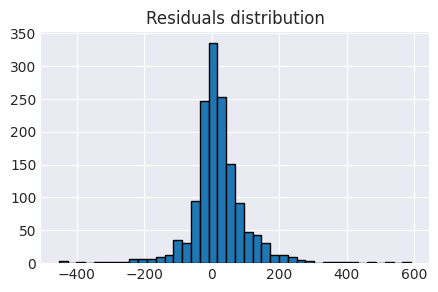

In [43]:
# Out-sample residuals distribution
# ==============================================================================
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())

fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(residuals, bins=40, edgecolor='black')
ax.set_title("Residuals distribution")
#ax.set_xlim(-300, 300)
plt.show();

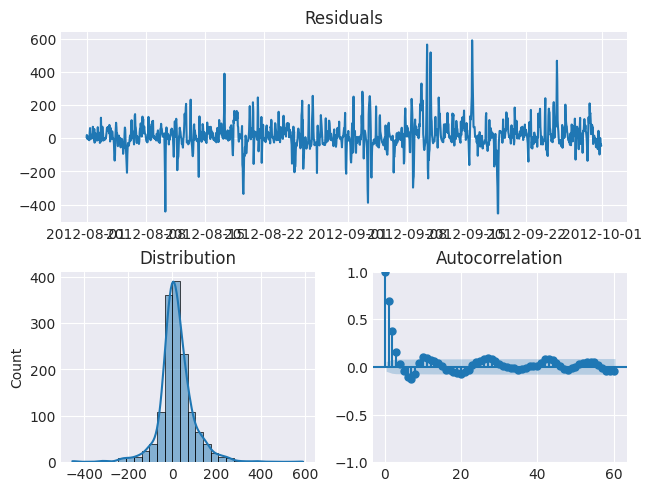

In [44]:
from skforecast.plot import plot_residuals

residuals = data.loc[predictions_val.index, 'users'] - predictions_val['pred']
_ = plot_residuals(residuals=residuals)

Text(0, 0.5, 'Residuals')

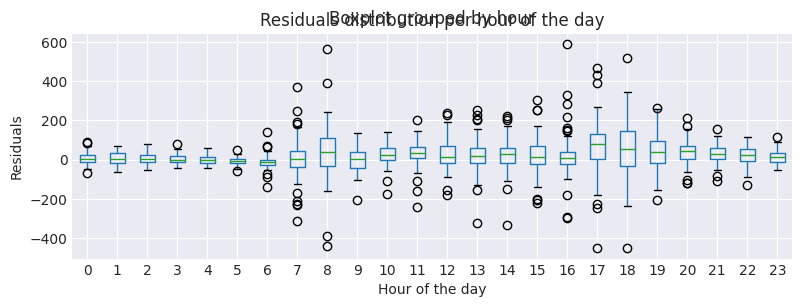

In [45]:
# Distribution of the residuals per hour of the day
# ==============================================================================
residuals_df = pd.DataFrame({
                      'residuals': residuals,
                      'hour': residuals.index.hour
                  })
# Plot distribution of residuals per hour of the day
fig, ax = plt.subplots(figsize=(9, 3))
residuals_df.boxplot(by='hour', ax=ax)
ax.set_title("Residuals distribution per hour of the day")
ax.set_xlabel("Hour of the day")
ax.set_ylabel("Residuals")


In [49]:
# Distribution of residuals per range of predicted values
# ==============================================================================
kbd = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample=10000)
kbd.fit(residuals_df[['pred']])

residuals_df['pred_bin'] = kbd.transform(residuals_df[['pred']]).astype(int)

# Create a dictionary that maps each bin to its interval
bin_intervals = {i: (kbd.bin_edges_[0][i], kbd.bin_edges_[0][i+1] if i+1 < len(kbd.bin_edges_[0]) else None)
                 for i in range(len(kbd.bin_edges_[0])-1)}

# conver to pandas interval
bin_intervals = {k: pd.Interval(left=v[0], right=v[1], closed='right') for k,v in bin_intervals.items()}
print(bin_intervals)

# Add a column with the interval of predicted bins
residuals_df['pred_bin_interval'] = residuals_df['pred_bin'].map(bin_intervals)
residuals_df.head()

{0: Interval(-60.2309245483874, 33.20230472739362, closed='right'), 1: Interval(33.20230472739362, 126.63553400317463, closed='right'), 2: Interval(126.63553400317463, 220.06876327895566, closed='right'), 3: Interval(220.06876327895566, 313.50199255473666, closed='right'), 4: Interval(313.50199255473666, 406.93522183051766, closed='right'), 5: Interval(406.93522183051766, 500.3684511062987, closed='right'), 6: Interval(500.3684511062987, 593.8016803820797, closed='right'), 7: Interval(593.8016803820797, 687.2349096578607, closed='right'), 8: Interval(687.2349096578607, 780.6681389336418, closed='right'), 9: Interval(780.6681389336418, 874.1013682094227, closed='right')}


,residuals,pred,pred_bin,pred_bin_interval
2012-08-01 00:00:00,5.585993,41.414007,1,"(33.20230472739362, 126.63553400317463]"
2012-08-01 01:00:00,19.985504,13.014496,0,"(-60.2309245483874, 33.20230472739362]"
2012-08-01 02:00:00,5.275003,7.724997,0,"(-60.2309245483874, 33.20230472739362]"
2012-08-01 03:00:00,-5.402116,12.402116,0,"(-60.2309245483874, 33.20230472739362]"
2012-08-01 04:00:00,-0.611052,4.611052,0,"(-60.2309245483874, 33.20230472739362]"


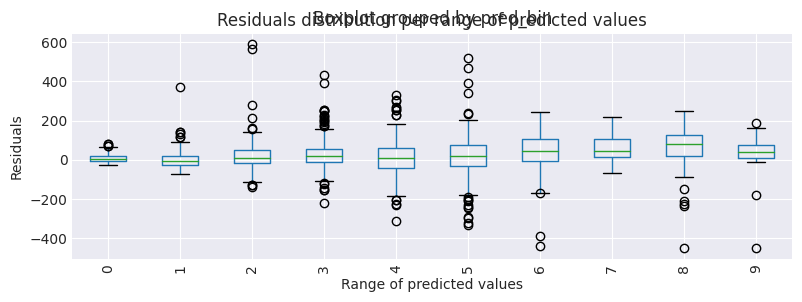

In [50]:
# Plot distribution of residuals per range of predicted values
fig, ax = plt.subplots(figsize=(9, 3))
residuals_df[['pred_bin', 'residuals']].boxplot(by='pred_bin', ax=ax)
ax.set_title("Residuals distribution per range of predicted values")
ax.set_xlabel("Range of predicted values")
ax.set_ylabel("Residuals")
plt.xticks(rotation=90);

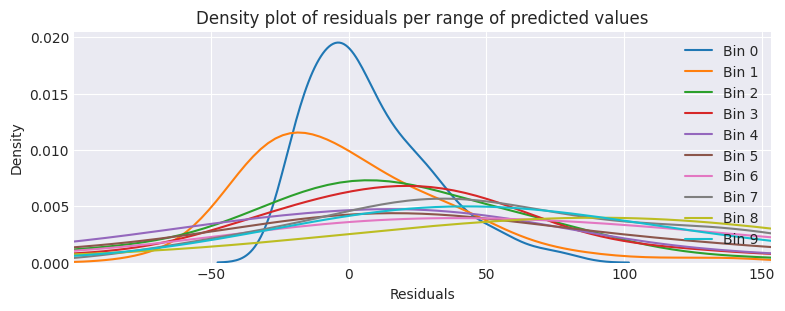

In [51]:
# Desnity plot of residuals per range of predicted values
# ==============================================================================
import seaborn as sns
fig, ax = plt.subplots(figsize=(9, 3))
for i in range(10):
    sns.kdeplot(residuals_df.loc[residuals_df['pred_bin'] == i, 'residuals'], label=f"Bin {i}", ax=ax)
ax.set_title("Density plot of residuals per range of predicted values")
ax.set_xlabel("Residuals")
ax.set_ylabel("Density")
# set limit ffrom the 10th to the 90th percentile
ax.set_xlim(residuals_df['residuals'].quantile(0.05), residuals_df['residuals'].quantile(0.95))
plt.legend()
plt.show();

Then, backtest in the test set using the out-of-sample residuals by setting the `in_sample_residuals` argument to `False`.

In [52]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster          = forecaster,
                          y                   = data['users'], # Full dataset
                          exog                = data[exog_features],
                          steps               = 36,
                          metric              = 'mean_absolute_error',
                          initial_train_size  = len(data.loc[:end_validation]),
                          refit               = False,
                          interval            = [10, 90],
                          n_boot              = 100,
                          in_sample_residuals = False, # Use out-sample residuals
                          n_jobs              = 'auto',
                          verbose             = False,
                          show_progress       = True
                      )
predictions.head(5)

  0%|          | 0/61 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2012-10-01 00:00:00,40.176411,-47.746269,116.137034
2012-10-01 01:00:00,17.989783,-57.726245,152.028040
2012-10-01 02:00:00,15.348796,-57.490890,165.496456
2012-10-01 03:00:00,14.675861,-83.675643,228.835677
2012-10-01 04:00:00,12.438828,-107.590783,228.081136


In [53]:
# Plot prediction intervals vs real value
# ==============================================================================
fig = go.Figure([
    go.Scatter(
        name='Prediction',
        x=predictions.index,
        y=predictions['pred'],
        mode='lines',
    ),
    go.Scatter(
        name='Real value',
        x=data_test.index,
        y=data_test['users'],
        mode='lines',
    ),
    go.Scatter(
        name='Upper Bound',
        x=predictions.index,
        y=predictions['upper_bound'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=predictions.index,
        y=predictions['lower_bound'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    )
])
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="users",
    width=900,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    hovermode="x",
    xaxis=dict(range=['2012-12-01', '2012-12-25']), # Initial zoom
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

In [54]:
# Predicted interval coverage (on test data)
# ==============================================================================
inside_interval = np.where(
                      (data.loc[end_validation:, 'users'] >= predictions["lower_bound"]) & \
                      (data.loc[end_validation:, 'users'] <= predictions["upper_bound"]),
                      True,
                      False 
                  )

coverage = inside_interval.mean()
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

Predicted interval coverage: 85.44 %
